In [1]:
import logging, sys
logging.disable(sys.maxsize)
import warnings
warnings.filterwarnings('ignore')

from types import SimpleNamespace
from extraction import *
import scipy.sparse as sp
from aind_ophys_utils.summary_images import pnr_image

2025-01-24 19:47:16.790973: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def csc_append(a, b):
    """Takes in 2 csc_matrices and appends the second one to the right of the first one.
    Much faster than scipy.sparse.hstack but assumes the type to be csc and overwrites
    the first matrix instead of copying it. The data, indices, and indptr still get copied."""
    a.data = np.concatenate((a.data, b.data))
    a.indices = np.concatenate((a.indices, b.indices))
    a.indptr = np.concatenate((a.indptr, (b.indptr + a.nnz)[1:]))
    a._shape = (a.shape[0], a.shape[1] + b.shape[1])

# define groundtruth functions
class Groundtruth:
    def __init__(self, name, only_soma=True, thresh_nearby=None):
        with h5py.File(name) as f:
            # get number of soma
            Nsoma = f["vol_out/gp_soma"].shape[1]
            # get ideal GT (w/o loading the profiles as dense array into RAM)
            self.dims = f["ideal"].shape[1:]
            batch = 10
            Ntmp = Nsoma if only_soma else f["ideal"].shape[0]
            As = ThreadPool(int(os.environ["CO_CPUS"])).map(
                lambda i: sp.csc_matrix(
                    f["ideal"][i : min(i + batch, Ntmp)].astype(np.float32).T.reshape((np.prod(self.dims), -1))
                ),
                range(0, Ntmp, batch),
            )
            A = As[0]
            for B in As[1:]:
                csc_append(A, B)
            # del As
            nonempty = np.ravel(A.sum(0)) > 0
            A = A[:, nonempty]
            idealTraces = f["idealTraces"][:, :Ntmp].T[nonempty]
            self.N = A.shape[1]
            # Get spikes and noiseless Ca traces
            C = f["neur_act"]["soma"][:].T[:Ntmp][nonempty]
            self.T = C.shape[1]
            spiketimes = np.where(f["spikes"]["somas"][:].T[:Ntmp][nonempty])
            S = np.zeros((self.N, self.T + 1), dtype=bool)
            S[spiketimes[0], np.round(spiketimes[1] * 0.3).astype(int)] = 1
            S = S[:, : self.T]
            # Get the locations of the neurons
            vol_sz = f["vol_params/vol_sz"][:, 0]
            locs = f["vol_out/locs"][:, : len(nonempty)][:, nonempty]
            locs[2] -= vol_sz[2] / 2  # Substract midpoint of volume (plane of imaging)
            locs[:2] -= 5  # Substract border
            locs = locs[np.array([1, 0, 2])].T
        if thresh_nearby is not None:
            nearby = np.abs(locs[:, 2]) < thresh_nearby
            A = A[:, nearby]
            C = C[nearby]
            S = S[nearby]
            idealTraces = idealTraces[nearby]
            locs = locs[nearby]
            self.N = C.shape[0]
        nA = sp.linalg.norm(A, 2, 0)
        A = A.dot(sp.diags(1 / nA))
        C *= nA[:, None]
        # sort by pnr
        #     o = np.argsort(-pnr_image(idealTraces.T, downscale=1))
        # sort by correlation between C and idealTraces
        o = np.argsort([np.corrcoef(c, i)[0, 1] for c, i in zip(C, idealTraces)])[::-1]
        self.A, self.C, self.S, self.idealTraces, self.locs = (
            A[:, o],
            C[o],
            S[o],
            idealTraces[o],
            locs[o],
        )
        self.pnr = pnr_image(self.idealTraces.T, downscale=1)

    def get_scales(self, mov, ds=10, maxiter=100):
        assert self.dims == mov.shape[1:]

        def obj(x, sub):
            return np.mean(
                (x[0] + reconstruct(self.A, self.C[:, ::sub] * np.atleast_2d(x[1:]).T, self.dims) - mov[::sub]) ** 2
            )

        x0 = np.concatenate([[0], np.ones(self.N) / 2])
        for sub in (100, 30):
            res = minimize(lambda x: obj(x, sub), x0, options={"maxiter": 3})
            x0 = res.x
        res = minimize(lambda x: obj(x, ds), x0, options={"maxiter": maxiter})
        return res.x[0], res.x[1:], res

    # scale A to fit movie
    def rescale(self, mov, ds=10, maxiter=100):
        foo = lambda self: np.corrcoef(reconstruct(self.A, self.C, self.dims).ravel(), mov.ravel())[0, 1]
        print(f"Correlation with movie\nbefore rescaling: {foo(self):.4f}")
        offset, scales, res = self.get_scales(mov, ds, maxiter)
        # self.A = self.A.dot(sp.diags(scales))
        self.C *= scales[:, None]
        print(f"after  rescaling:  {foo(self):.4f}")

    def is_nearby(self, thresh=20):
        return np.abs(self.locs[:, 2]) < thresh

    def is_inFOV(self, border=0):
        locs = self.locs
        return (
            (locs[:, 0] < self.dims[0] - border)
            * (locs[:, 0] > border)
            * (locs[:, 1] < self.dims[1] - border)
            * (locs[:, 1] > border)
        )

    def is_bright(self, thresh=0.25, order=2):
        # ord=1: sum of pixels == 1-norm,  ord=np.inf: max of pixels == inf-norm
        maxAC = np.maximum(sp.linalg.norm(self.A, ord=order, axis=0) * self.C.max(1), 0)
        return maxAC > np.median(maxAC[maxAC > 0]) * thresh

    def is_active(self):
        return self.S.sum(1) > 0

    def plot_traces(self, fit=True):
        C, S, idealTraces, AtY = self.C, self.S, self.idealTraces, self.AtY

        def s2c(s, x):
            return x[0] + x[1] * np.convolve(s, np.exp(-np.arange(self.T) / 30 / x[2]))[: self.T]

        N = len(C)
        plt.figure(figsize=(20, N / 2))
        for i in range(N):
            plt.subplot((N - 1) // 5 + 1, 5, 1 + i)
            plt.plot(idealTraces[i], c="C2", label="ideal")
            plt.legend(
                fontsize="xx-small",
                title_fontsize="xx-small",
                loc=1,
                title=f"r={np.corrcoef(C[i], idealTraces[i])[0,1]:.3f}",
            )
            plt.xticks([])
            divider = make_axes_locatable(plt.gca())
            divider.append_axes("top", size="150%", pad=0.05)
            for s in np.where(S[i])[0]:
                plt.axvline(s, c="grey", alpha=0.3)
            if S[i].sum():
                plt.plot(C[i], label="C")
                plt.legend(fontsize="xx-small", loc=1)
                if fit:

                    def obj(x):
                        return np.sum((s2c(S[i], x) - C[i]) ** 2)

                    res = minimize(
                        obj,
                        (1, 0.1, 1.7),
                        bounds=((0, np.inf), (0, np.inf), (0, np.inf)),
                    )
                    plt.plot(s2c(S[i], res.x), "--")
                    plt.title("b={0:.3f}  a={1:.3f}  tau={2:.3f}".format(*res.x))
            else:
                plt.title("inactive")
            plt.xticks([])
            divider.append_axes("bottom", size="100%", pad=0.05)
            plt.plot(AtY[i] / 100, c="C3", label="AtY")
            plt.legend(
                fontsize="xx-small",
                title_fontsize="xx-small",
                loc=1,
                title=f"r={np.corrcoef(C[i], AtY[i])[0,1]:.3f}",
            )
        plt.tight_layout()

In [3]:
args = SimpleNamespace(
        input_dir="../data/",
        output_dir="../results/",
        tmp_dir="/scratch",
        diameter=0,
        anatomical_only=2,
        denoise=False,
        cellprob_threshold=0.0,
        flow_threshold=1.5,
        spatial_hp_cp=0,
        pretrained_model="cyto",
        neuropil="CNMF",
        contour_video=False,
    )

In [4]:
    output_dir = Path(args.output_dir).resolve()
    input_dir = Path(args.input_dir).resolve()
    tmp_dir = Path(args.tmp_dir).resolve()
    session, data_description, subject = get_metdata(input_dir)
    subject_id = subject.get("subject_id", "")
    name = data_description.get("name", "")
    setup_logging("aind-ophys-extraction-suite2p", mouse_id=subject_id, session_name=name)
    if next(input_dir.rglob("*decrosstalk.h5"), ""):
        input_fn = next(input_dir.rglob("*decrosstalk.h5"))
    else:
        input_fn = next(input_dir.rglob("*registered.h5"))
    parent_directory = input_fn.parent
    if session is not None and "Bergamo" in session["rig_id"]:
        motion_corrected_fn = bergamo_segmentation(input_fn, session, temp_dir=tmp_dir)
    else:
        motion_corrected_fn = input_fn
    if not data_description or "multiplane" in data_description.get("name", ""):
        unique_id = motion_corrected_fn.parent.parent.name
    else:
        unique_id = "_".join(str(data_description["name"]).split("_")[-3:])

    frame_rate = get_frame_rate(session)

    output_dir = make_output_directory(output_dir, unique_id)

In [5]:
    # Run Cellpose via Suite2p to get ROI seeds
    # =========================================
    # Set suite2p args.
    suite2p_args = suite2p.default_ops()
    # Overwrite the parameters for suite2p that are exposed
    suite2p_args["diameter"] = args.diameter
    suite2p_args["anatomical_only"] = args.anatomical_only
    suite2p_args["cellprob_threshold"] = args.cellprob_threshold
    suite2p_args["flow_threshold"] = args.flow_threshold
    suite2p_args["spatial_hp_cp"] = args.spatial_hp_cp
    suite2p_args["pretrained_model"] = args.pretrained_model
    suite2p_args["denoise"] = args.denoise
    suite2p_args["save_path0"] = args.tmp_dir
    # Here we overwrite the parameters for suite2p that will not change in our
    # processing pipeline. These are parameters that are not exposed to
    # minimize code length. Those are not set to default.
    suite2p_args["h5py"] = str(motion_corrected_fn)
    suite2p_args["data_path"] = []
    suite2p_args["roidetect"] = True
    suite2p_args["do_registration"] = 0
    suite2p_args["spikedetect"] = False
    suite2p_args["fs"] = frame_rate
    suite2p_args["neuropil_extract"] = True

    # determine nbinned from bin_duration and fs
    suite2p_args["bin_duration"] = 3.7  # The duration of time (in seconds) that
    # should be considered 1 bin for Suite2P ROI detection purposes. Requires
    # a valid value for 'fs' in order to derive an
    # nbinned Suite2P value. This allows consistent temporal downsampling
    # across movies with different lengths and/or frame rates.
    with h5py.File(suite2p_args["h5py"], "r") as f:
        nframes = f["data"].shape[0]
    bin_size = suite2p_args["bin_duration"] * suite2p_args["fs"]
    suite2p_args["nbinned"] = int(nframes / bin_size)
    try:
        suite2p.run_s2p(suite2p_args)
    except IndexError:  # raised when no ROIs found
        pass

    # load in the rois from the stat file and movie path for shape
    with h5py.File(str(motion_corrected_fn), "r") as open_vid:
        dims = open_vid["data"][0].shape
    if len(list(Path(args.tmp_dir).rglob("stat.npy"))):
        suite2p_stat_path = str(next(Path(args.tmp_dir).rglob("stat.npy")))
        suite2p_stats = np.load(suite2p_stat_path, allow_pickle=True)

{}
FOUND BINARIES AND OPS IN ['/scratch/suite2p/plane0/ops.npy']
removing previous detection and extraction files, if present
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not running registration, ops['do_registration']=0
binary path: /scratch/suite2p/plane0/data.bin
NOTE: Applying builtin classifier at /opt/conda/lib/python3.10/site-packages/suite2p/classifiers/classifier.npy
----------- ROI DETECTION
Binning movie in chunks of length 113
Binned movie of size [22,90,90] created in 0.03 sec.
>>>> CELLPOSE finding masks in mean_img
!NOTE! diameter set to 0 or None, diameter will be estimated by cellpose
>>>> 4 masks detected, median diameter = 10.20 
Detected 4 ROIs, 7.53 sec
After removing overlaps, 4 ROIs remain
----------- Total 9.35 sec.
----------- EXTRACTION
Masks created, 0.03 sec.
Extracted fluorescence from 4 ROIs in 2500 frames, 6.64 sec.
----------- Total 6.70 sec.
----------- CLASSIFICATION
['npix_norm', 'skew', 'compact']
Plane 0 processed in 16.41 sec (can op

In [6]:
def caiman2stats(A):
    rois = A.toarray().reshape(dims + (-1,)).T
    o = (rois>0).sum(0)>1
    stats = []
    for r in rois:
        coo = np.where(r)
        stats.append({"ypix":coo[0], "xpix":coo[1], "lam": r[coo], "radius":5, "overlap": o[coo]})
    return stats

def run_suite2p(args, Ain=None):
            # Run Suite2p to extract traces
            # =============================
            if Ain is None:  # all frames have already been used for detection as well as extraction
                suite2p_f_path = str(next(Path(args.tmp_dir).rglob("F.npy")))
                suite2p_fneu_path = str(next(Path(args.tmp_dir).rglob("Fneu.npy")))
                traces_roi = np.load(suite2p_f_path, allow_pickle=True)
                traces_neuropil = np.load(suite2p_fneu_path, allow_pickle=True)
            else:
                # extract signals for all frames, not just those used for cell detection
                stat, traces_roi, traces_neuropil, _, _ = (
                    suite2p.extraction.extraction_wrapper(
                        caiman2stats(A=Ain), h5py.File(input_fn)["data"], ops=suite2p_args
                    )
                )
            iscell = np.load(str(next(Path(args.tmp_dir).rglob("iscell.npy"))))
            if args.neuropil.lower() == "suite2p":
                traces_corrected = traces_roi - suite2p_args["neucoeff"] * traces_neuropil
                r_values = suite2p_args["neucoeff"] * np.ones(traces_roi.shape[0])
            else:
                traces_corrected, r_values, raw_r = get_FC_from_r(traces_roi, traces_neuropil)
            return traces_corrected, traces_neuropil, traces_roi


def run_caiman(args, Ain=None, x=None):
            # Run CaImAn to update ROIs and extract traces
            # ============================================
            if Ain is None:
                Ain = hstack([
                    coo_matrix((roi["lam"], (roi["ypix"], roi["xpix"])), shape=dims).reshape((-1,1), order="F").tocsc()
                    for roi in suite2p_stats
                ])
            cnmfe = args.neuropil.lower() == "cnmf-e"
            # set parameters
            gSig = 6  # TODO: set gSig based on suite2p diameter estimate
            opts = params.CNMFParams(params_dict={'K': None,
                                                  'p': 1,
                                                  'nb': 0 if cnmfe else 2,
                                                  'only_init': cnmfe,
                                                  'merge_thr': 1,
                                                  'method_init': 'corr_pnr' if cnmfe else 'greedy_roi',
                                                  'gSig': (gSig,) * 2,
                                                  'gSiz': (int(round(gSig * (4 if cnmfe else 2) + 1)),) * 2,
                                                  'normalize_init': False,
                                                  'center_psf': True,
                                                  'init_iter': 1,
                                                  'tsub': 1,
                                                  'ssub': 1,
                                                  'min_corr': 0,
                                                  'min_pnr': 0,
                                                  'seed_method': caiman.base.rois.com(Ain, *dims)
                                                 })
            # fit
            cnm = cnmf.CNMF(1, params=opts, Ain=None if cnmfe else (Ain > 0).toarray())
            movie = h5py.File(motion_corrected_fn)["data"][:].astype("f4")
            cnm.fit(movie)
            e = cnm.estimates
            assert np.allclose(linalg.norm(e.A, 2, 0), 1)
            traces_corrected = (e.C + e.YrA).astype("f4")
            if cnmfe: 
                traces_corrected += e.A.T.dot(e.b0)[:, None]
                e.b, e.f, e.dims = None, None, dims  # required patch for next line
                traces_neuropil = e.A.astype("f4").T.dot(e.compute_background(caiman.movie(movie).to2DPixelxTime()))
            else:
                traces_neuropil = e.A.T.dot(e.b).dot(e.f).astype("f4")
                traces_corrected += x*traces_neuropil
            traces_roi = (e.C + e.YrA + traces_neuropil).astype("f4")
            # convert ROIs to sparse COO 3D-tensor  a la https://sparse.pydata.org/en/stable/construct.html
            data = []
            coords = []
            for i in range(e.A.shape[1]):
                roi = coo_matrix(e.A[:,i].reshape(dims, order="F").toarray(), dtype="f4")
                data.append(roi.data)
                coords.append(np.array([i*np.ones(len(roi.data)), roi.row, roi.col], dtype="i2"))
            if len(data):
                data = np.concatenate(data)
                coords = np.hstack(coords)  
                
            # TODO: save background, use caiman's classifier for iscell
            neuropil_coords, iscell, keys = [[]] * 3
            
            return traces_corrected, traces_neuropil, traces_roi

In [7]:
gt = Groundtruth("/data/NAOMi/small.h5")

In [8]:
def scale(t, g):
    tm, gm = t.mean(), g.mean()
    m = np.sum((t - tm) * (g - gm)) / np.sum((t - tm) ** 2)
    c = gm - m * tm
    return c, m

spatial support for each components given by the user


(0.35622304210614253, 1.1)

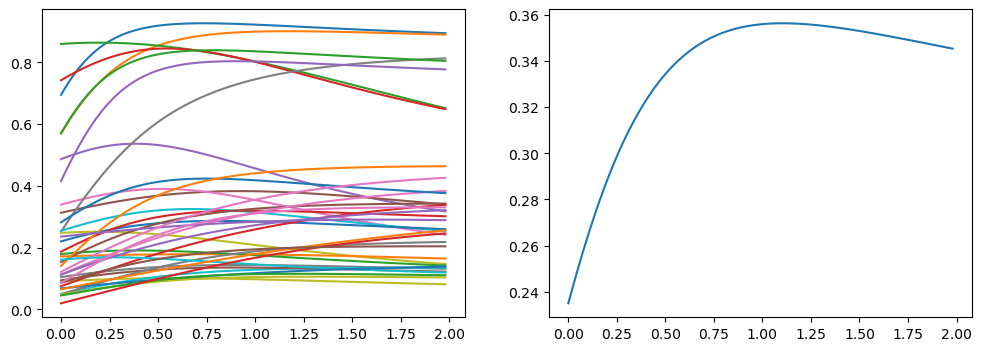

In [9]:
args.neuropil = "cnmf"
traces_corrected, traces_neuropil, traces_roi = run_caiman(args, gt.A, x=0)

xvals = np.arange(0, 2, .02)
plt.figure(figsize=(12,4))
plt.subplot(121)
for k,t in enumerate(traces_corrected):
    i = np.argmax([np.corrcoef(t, c)[0,1] for c in gt.C])
    plt.plot(xvals, [np.corrcoef(t + x*traces_neuropil[k], gt.C[i])[0,1] for x in xvals])
plt.subplot(122)
xs = []
for k,t in enumerate(traces_corrected):
    i = np.argmax([np.corrcoef(t, c)[0,1] for c in gt.C])
    xs.append([np.corrcoef(t + x*traces_neuropil[k], gt.C[i])[0,1] for x in xvals])
plt.plot(xvals, np.mean(xs,0))
np.max(np.mean(xs,0)), xvals[np.argmax(np.mean(xs,0))]

initialized with Cellpose
suite2p kept 4 ROIs
mutualinfo kept 4 ROIs
spatial support for each components given by the user
cnmf kept 4 ROIs
cnmf-e kept 4 ROIs


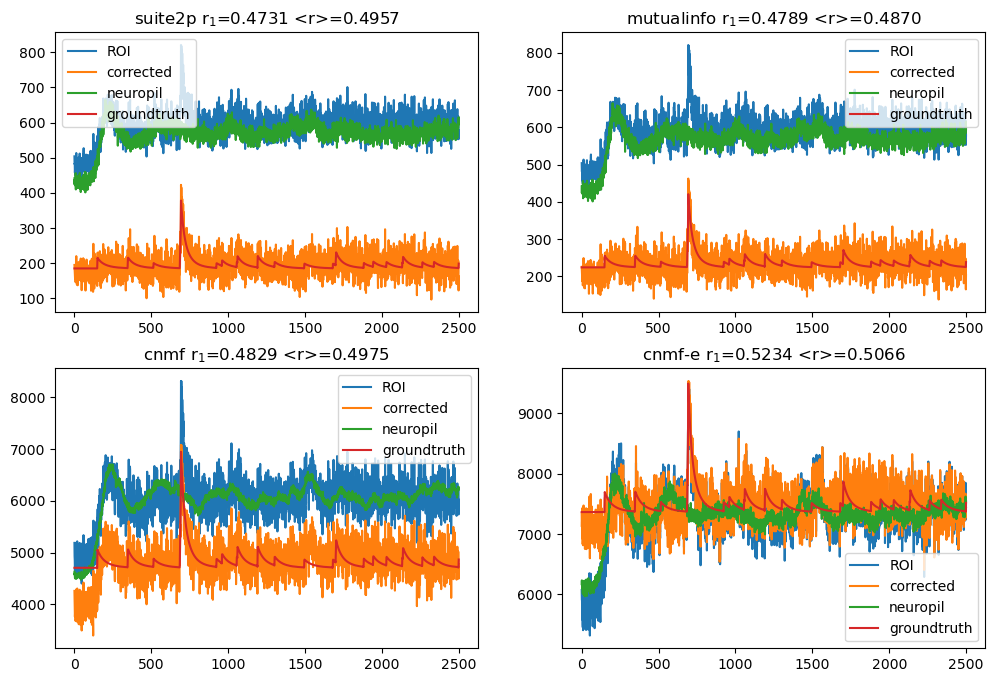

initialized with grount truth
Masks created, 0.07 sec.
Extracted fluorescence from 37 ROIs in 2500 frames, 1.47 sec.
suite2p kept 37 ROIs
Masks created, 0.07 sec.
Extracted fluorescence from 37 ROIs in 2500 frames, 1.64 sec.
mutualinfo kept 37 ROIs
spatial support for each components given by the user
cnmf kept 37 ROIs
cnmf-e kept 35 ROIs


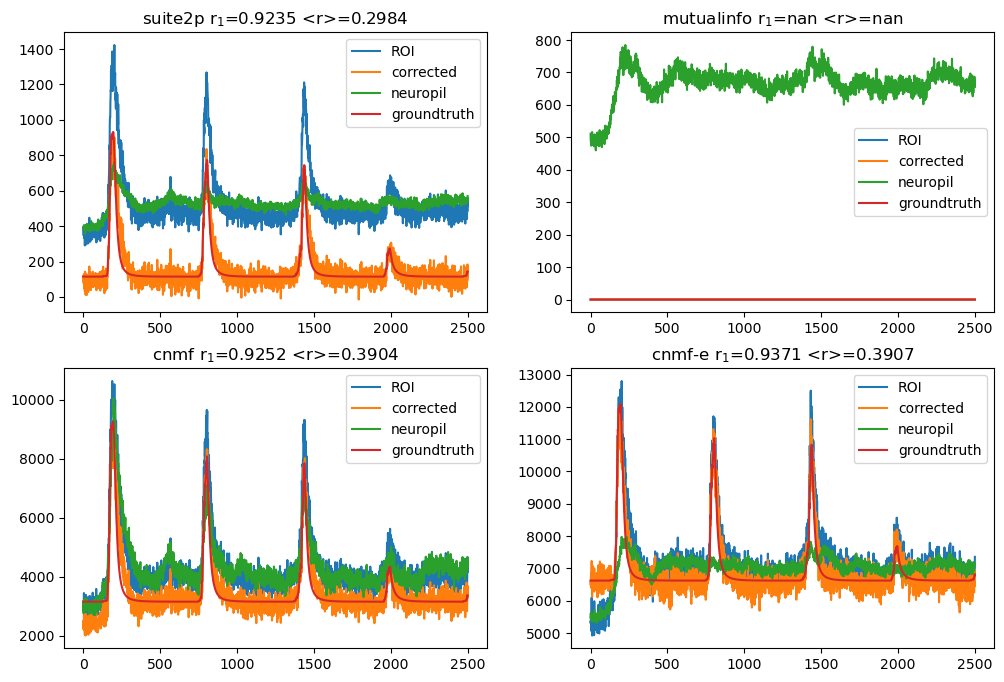

In [11]:
for Ain in (None, gt.A):
    print('\033[1m' + f"initialized with {'Cellpose' if Ain is None else 'ground truth'}" + '\033[0m')
    plt.figure(figsize=(12,8))
    for m in range(4):
        args.neuropil = ("suite2p", "mutualinfo", "cnmf", "cnmf-e")[m]
        traces_corrected, traces_neuropil, traces_roi = run_suite2p(args, Ain) if m<2 else run_caiman(args, Ain, x=.8)
        print(args.neuropil, f"kept {len(traces_roi)} ROIs")
        if m==0:
            i = 0 #if Ain is None else 1
            t_s2p = traces_corrected[i]
        else:
            i = np.argmax([np.corrcoef(t, t_s2p)[0,1] for t in traces_corrected])
        corrs = [[np.corrcoef(t, c)[0,1] for c in gt.C] for t in traces_corrected]
        j = np.argmax(corrs[i])
        plt.subplot(2,2,1+m)
        plt.plot(traces_roi[i], label='ROI')
        plt.plot(traces_corrected[i], label='corrected')
        plt.plot(traces_neuropil[i], label='neuropil')
        offset, slope = scale(gt.C[j], traces_corrected[i])
        plt.plot(offset + slope*gt.C[j], label='groundtruth')
        plt.title(f"{args.neuropil} r$_1$={corrs[i][j]:.4f} <r>={np.max(corrs, 1).mean():.4f}")
        plt.legend()
    plt.show()